## Оценка модели по скользящему контролю

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
X, y = datasets.make_regression(n_samples=5000, n_features=5, n_informative=3)

In [3]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None

In [4]:
class DecisionTree:
    def __init__(self, min_samples=2, max_depth=20):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.tree = []
    
    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])
    
    def constant_prediction(self, y):
        return np.sum(y) / len(y)

    def loss_function(self, y):
        c = np.sum(y) / len(y)
        mse = np.sum((c - y)**2) / len(y)
        mae = np.sum(np.abs(c - y)) / len(y)
        return mse
    
    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_gain = -1
        
        indexes = np.random.choice(X.shape[1])
        
        for i in range(X.shape[1]):
#         for i in [indexes]:
            thresholds = np.unique(X[:, i])
            for threshold in thresholds:
                gain = self.information_gain(X[:, i], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold
        return best_feature, best_threshold
    
    def information_gain(self, X_column, y, threshold):        
        n = len(y)
        parent = self.loss_function(y)
        
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()
        
        if len(left_indexes) == 0 or len(right_indexes) == 0:
            return 0
        
        e_l, n_l = self.loss_function(y[left_indexes]), len(left_indexes)
        e_r, n_r = self.loss_function(y[right_indexes]), len(right_indexes)
        
        child = (n_l / n) * e_l + (n_r / n) * e_r
        return parent - child
    
    def grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_labels = len(np.unique(y))
        
        if n_samples < self.min_samples or n_labels == 1 or depth >= self.max_depth:
            return Node(value=self.constant_prediction(y))
        
        best_feature, best_threshold = self.best_split(X, y)
        
        left_indexes = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        
        left = self.grow_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self.grow_tree(X[right_indexes, :], y[right_indexes], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        if x[tree.feature] <= tree.threshold:
            return self.travers_tree(x, tree.left)
        return self.travers_tree(x, tree.right)

In [5]:
class GBM:
    def __init__(self, n_estimators=10, max_depth=3, min_samples=1, lr=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.trees = []
        self.residuals = []
        self.first_leaf = None
        self.lr = 0.1
        self.train_score = []
        self.threshold = None
        self.labels = []
        self.y = []
        self.X = []
        
    def fit(self, X, y):
        self.first_leaf = y.mean()
        prediction = np.ones(len(y)) * self.first_leaf
        
        for i in range(self.n_estimators):
            residuals = y - prediction
            self.residuals.append(residuals)
            
            tree = DecisionTree(max_depth=self.max_depth, min_samples=self.min_samples)
            tree.fit(X, residuals)
            self.trees.append(tree)
            self.train_score.append(self.score(self.predict(X, len(self.trees)), y))
            
            prediction += self.lr * tree.predict(X)
            
    def predict(self, X, n=None):
        if n is None: n = self.n_estimators
        predictions = np.ones(X.shape[0]) * self.first_leaf
        
        for i in range(n):
            predictions += self.lr * self.trees[i].predict(X)
        
#         self.threshold = np.mean(predictions)
#         labels = [0 if i <= self.threshold else 1 for i in predictions]
        
        return predictions
    
#     def score(self, predicted, y):
#         return np.sum(predicted == y) / len(y)

    def score(self, predicted, y):
        return 1 - np.sum((predicted - y)**2) / np.sum((y.mean() - y)**2)
    
#     def roc(self, X, y, n = None, min_precision = 0.8):
#         if n is None: n = self.n_estimators
#         predictions = np.ones(X.shape[0]) * self.first_leaf
        
#         for i in range(n):
#             predictions += self.lr * self.trees[i].predict(X)
            
#         indexes = np.argsort(predictions)[::-1]    
#         TPR, FPR, P, R = 0, 0, 0, 0
        
#         for gap in predictions[indexes]:
#             labels = [0 if i <= gap else 1 for i in predictions]

#             TP, FP, FN, TN = 0, 0, 0, 0

#             for i in range(len(labels)):
#                 if labels[i] == 0 and y[i] == 0: TP += 1
#                 if labels[i] == 1 and y[i] == 1: TN += 1
#                 if labels[i] == 0 and y[i] == 1: FP += 1
#                 if labels[i] == 1 and y[i] == 0: FN += 1                        

#             TPR = (TP / (TP + FN))
#             FPR = (FP / (FP + TN))
#             R = (TP / (TP + FN))
#             P = (TP / (TP + FP))

#             if P > min_precision:
#                 break
        
#         return TPR, FPR, P, R      

    def cv(self, X, y, cv=10):
        y = np.reshape(y, (len(y), 1))
        data = np.concatenate((X, y), axis=1)
        np.random.shuffle(data)
        
        data = pd.DataFrame(data)
        accuracy = []
        
        P, R = [], []
        
        for i in tqdm(range(cv)):
            lenght = int(len(y) / cv)
            end = i * lenght + lenght
            
            if i == cv - 1: 
                end = -1
            
            X_test = data.iloc[i * lenght: end, :-1]
            X_train = data.drop(index=X_test.index).iloc[:, :-1]
            
            y_test = data.iloc[i * lenght: end, -1]
            y_train = data.drop(index=X_test.index).iloc[:, -1]
            
            clf = GBM()
            clf.fit(np.array(X_train), np.array(y_train))
            
            accuracy.append(self.score(clf.predict(np.array(X_test)), np.array(y_test)))
            
            self.labels.append(clf.predict(np.array(X_test)))
            self.y.append(np.array(y_test))
            self.X.append(np.array(X_test))

        return accuracy

In [6]:
clf = GBM(n_estimators=30, max_depth=3, lr=0.1)
r2 = clf.cv(X, y, cv=10)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [26:53<00:00, 161.34s/it]


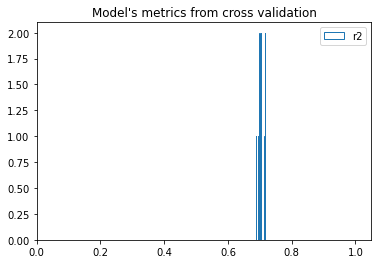

In [62]:
plt.hist(r2, label="r2", bins=20, histtype="step")
plt.legend()
plt.title("Model's metrics from cross validation")
plt.xlim(0.0, 1.05)
plt.savefig("r2.png")
plt.show()

In [63]:
df = pd.DataFrame(clf.X[0][:, :5], columns=["X0", "X1", "X2", "X3", "X4"])
df["y"] = clf.y[0].astype(int)
df["labels"] = clf.labels[0]

B = 5
pb = np.random.poisson(1, [len(clf.y[0]), B])

for i in range(B):
    df["b" + str(i)] = pb[:, i]

print("*** Data and labels from the first fold of cross validation ***")
df.sample(10)

*** Data and labels from the first fold of cross validation ***


,X0,X1,X2,X3,X4,y,labels,b0,b1,b2,b3,b4
188,0.819239,-0.094555,-1.209262,-0.131128,-0.544196,-27,1.057282,3,1,2,1,2
354,1.831594,1.073355,-0.735654,0.073380,1.668444,124,35.341036,1,0,3,1,0
98,1.224773,1.828570,-1.088847,1.137558,-0.099387,17,7.253636,0,2,1,1,1
346,0.967673,0.213736,-0.184513,0.789442,1.038730,81,28.073682,1,1,2,0,1
355,1.360334,-0.337291,-0.814275,-0.874890,1.511346,84,22.201354,3,0,0,0,2
318,-0.442565,1.109052,-1.669531,0.773916,1.089720,-96,-69.760346,2,0,3,1,1
162,-0.919113,-0.814049,0.073510,-0.299959,-0.226849,-63,-31.621136,0,1,2,1,1
23,-2.238698,-0.006450,1.203413,0.014772,0.223556,-76,-16.796488,0,1,0,1,1
337,0.760865,0.838277,0.549861,-0.489319,0.813946,103,52.775311,1,0,1,0,1
498,0.274038,-0.241449,2.386236,1.117444,-0.855137,131,51.609444,1,2,1,1,0


## Оценка модели используя бутстрап

In [64]:
def run_bootstrap(labels, y, method="poisson"):
    N = len(y)
    B = 1000
    
    if method == "poisson":
        bootstrap = np.random.poisson(1, [N, B])
    if method == "multinomial":
        bootstrap = np.random.multinomial(B, [1/B]*B, N)
    if method == "binomial":
        bootstrap = np.random.binomial(N, 1/N, [N, B])
    
    R = []
    
    for i in range(B):
        Y, L = [], []
        
        for j in range(N):
            for k in range(bootstrap[j][i]):
                L.append(labels[j])
                Y.append(y[j])
        
        L = np.array(L)
        Y = np.array(Y)
        
        R.append(1 - np.sum((L - Y)**2) / np.sum((Y.mean() - Y)**2))
                
    return R

*** Estimating model by bootsraping its predicted labels for each fold ***
*** poisson ***


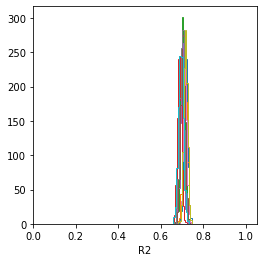

*** multinomial ***


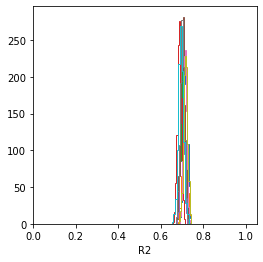

*** binomial ***


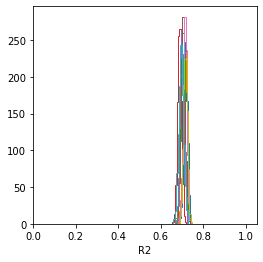

In [65]:
print("*** Estimating model by bootsraping its predicted labels for each fold ***")

for bs in ["poisson", "multinomial", "binomial"]:
    plt.subplots(figsize=(4, 4))
    
    for i in range(len(clf.labels)):
        R = run_bootstrap(clf.labels[i], clf.y[i], bs)

        plt.hist(R, histtype="step")
        plt.xlim(0, 1.05)
        plt.xlabel("R2")

    print("*** " + bs + " ***")
    plt.savefig("r2_.png")
    plt.show()